In [1]:
import autograd.numpy as np
from autograd import grad, hessian, jacobian
from scipy.optimize import minimize

In [2]:
import matplotlib.pyplot as plt
from counterfactual_functions import *
from helper import *

username='ozaltun'

data_dict = load_obj('/Users/'+username+'/Dropbox (MIT)/Data/Trade/general_equilibrium_gravity/final_data/data_subset_20200304.pickle')

reg_2_num = load_obj('/Users/'+username+'/Dropbox (MIT)/Data/Trade/general_equilibrium_gravity/GTAP/mapping/reg_2_num.pickle')
comm_2_num = load_obj('/Users/'+username+'/Dropbox (MIT)/Data/Trade/general_equilibrium_gravity/GTAP/mapping/comm_2_num.pickle')

n = data_dict['n']
g = data_dict['g']
k = data_dict['k']

data_dict['R_hat'] = np.ones((n, g))
data_dict['R_hat'][reg_2_num['usa'], 3] = 2.
data_dict['R_hat'][reg_2_num['usa'], 4] = 2.

# Farrokhi 2019 oil trade elasticity 19.77
# Ossa 2015 has coal at ~4
# Lets assume NG of ~2
data_dict['theta_g'][2] = 5.
data_dict['theta_g'][3] = 8.
data_dict['theta_g'][4] = 2.




X_0 = np.ones(n*g + n)*0.5


eval_F = lambda x: reduced_counterfactual_overdetermined(x, data_dict)
eval_f = lambda x: np.sum(eval_F(x)**2)
# eval_f = lambda x: np.linalg.norm(eval_F(x))

eval_grad_f = grad(eval_f)
eval_jac_F = jacobian(eval_F)
eval_hess_f = hessian(eval_f)
bounds_f = [(1e-14, None) for x in range(n*g+n)]

In [3]:
sol = minimize(eval_f, X_0*2, jac=eval_grad_f, hess=eval_hess_f,\
               method="Newton-CG",bounds=bounds_f, options={'xtol':1e-9,'disp':True})

r_hat_star, w_hat_star = get_values_from_X_reduced(sol.x, data_dict)
E_hat_star = get_E_hat(w_hat_star, r_hat_star, data_dict)

E_hat_star.sum() 

'''Note that you comparing the sum of E_hat doesn't make sense. And we would expect it to change depending on which
country we normalize with respect to. Since the sum of E_hat doesn't take into account the different sizes
of countries. So if you make the normalizing country a small one, thenn the sum will probably be more since you 
are standardizing the small country.
'''

/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: 0.000270
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 46
         Hessian evaluations: 22


"Note that you comparing the sum of E_hat doesn't make sense. And we would expect it to change depending on which\ncountry we normalize with respect to. Since the sum of E_hat doesn't take into account the different sizes\nof countries. So if you make the normalizing country a small one, thenn the sum will probably be more since you \nare standardizing the small country.\n"

In [6]:
r_hat_star[reg_2_num['usa'], 2]

1.0150738597959255

In [4]:
r_hat_star[reg_2_num['usa'], 3]

0.6865865010996155

In [5]:
r_hat_star[reg_2_num['usa'], 4]

0.450967697941815

In [9]:
import seaborn as sns

In [10]:
C_goods = ['farm', 'food', 'coa', 'oil','gas', 'oxd']
F_goods = ['man','bus','oxd','trans','util']
num_2_reg = reverse_dict(reg_2_num)

df_temp = pd.DataFrame(r_hat_star.T)
df_temp.set_index(pd.Series(C_goods), inplace=True)
df_temp.rename(columns=num_2_reg, inplace=True)

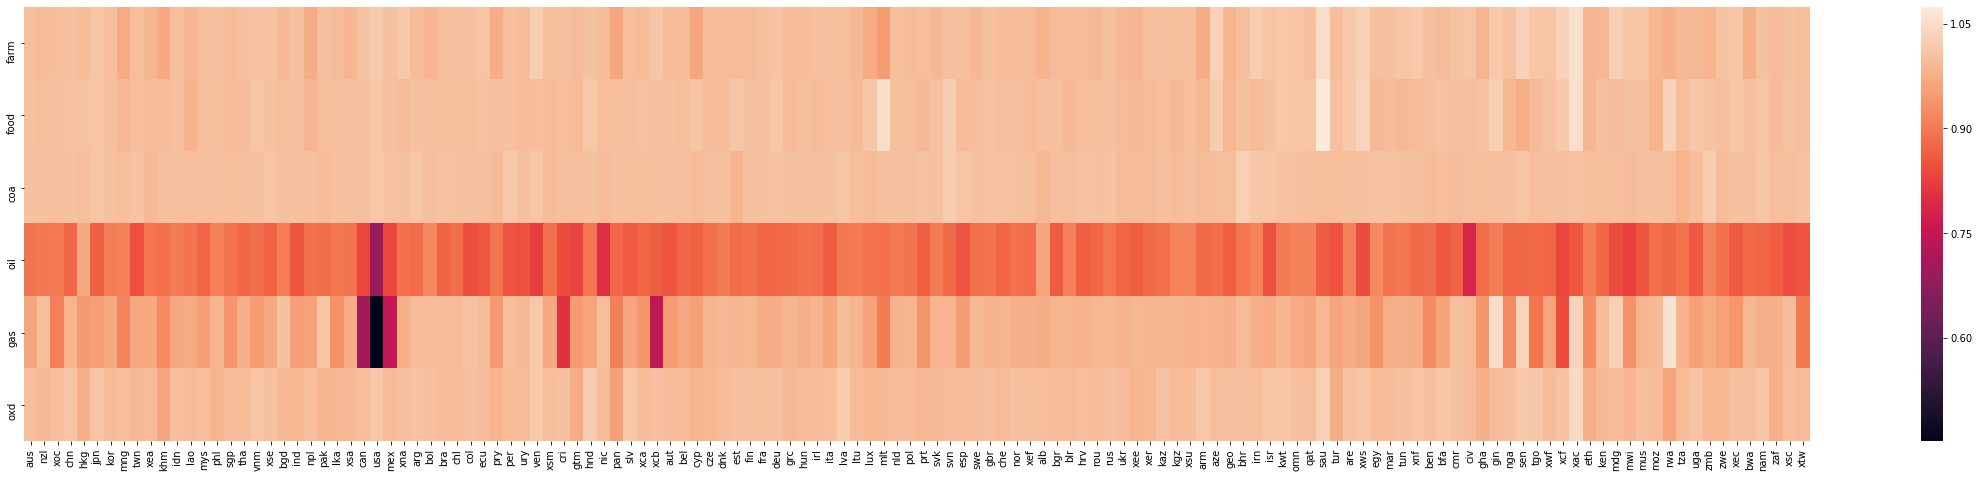

In [11]:
fig, ax = plt.subplots(figsize=(40, 8))
ax = sns.heatmap(df_temp)

plt.show()

In [12]:
C_goods = ['farm', 'food', 'coa', 'oil','gas', 'oxd']
F_goods = ['man','bus','oxd','trans','util']
num_2_reg = reverse_dict(reg_2_num)

df_temp = pd.DataFrame(w_hat_star.T)
df_temp.set_index(pd.Series(['Wage']), inplace=True)
df_temp.rename(columns=num_2_reg, inplace=True)

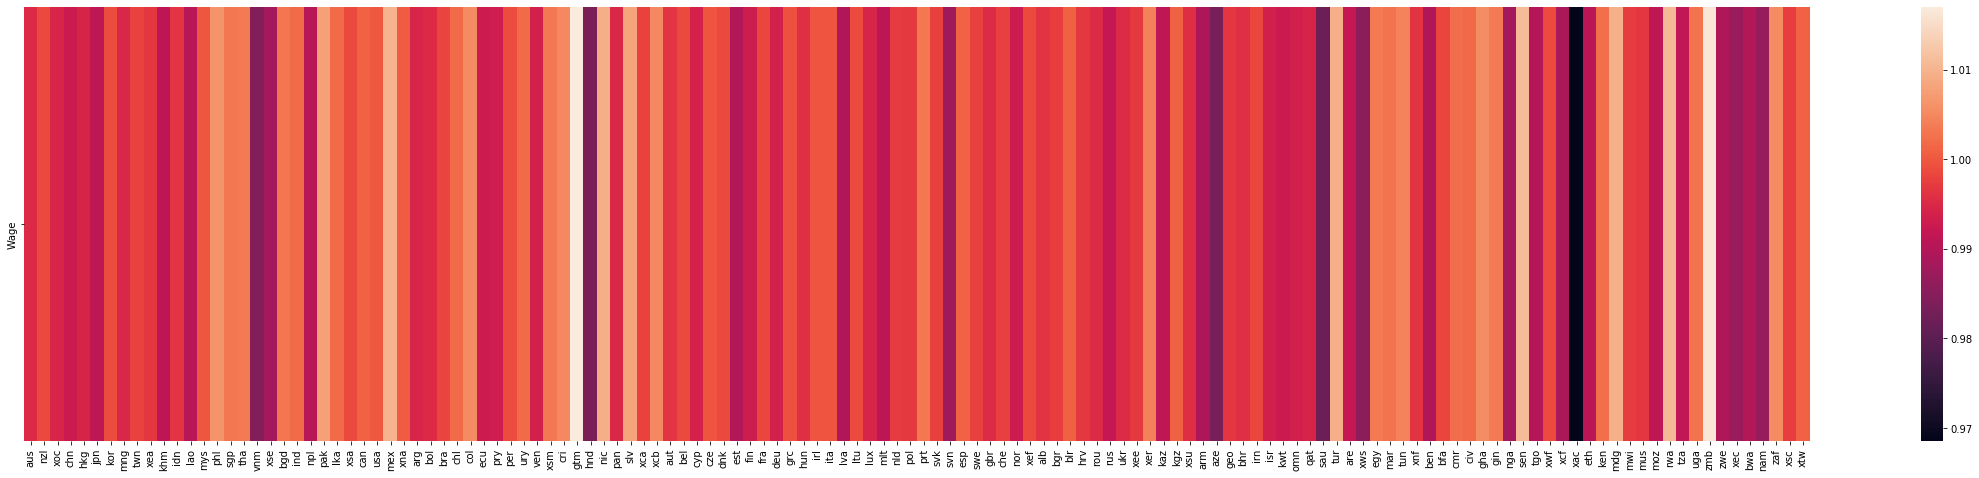

In [13]:
fig, ax = plt.subplots(figsize=(40, 8))
ax = sns.heatmap(df_temp)

plt.show()

In [14]:
def get_X_g_hat(C_g_hat, P_g_goods_hat, D_g_hat, data):
    n = data['n']
    g = data['g']
    k = data['k']
    
    part1 = (P_g_goods_hat.reshape((n, 1, g))/C_g_hat.reshape((1, n, g))) ** (data['theta_g'].reshape((1, 1, g)))
    
    X_g_hat = part1*D_g_hat.reshape((n, 1, g))
    
    return X_g_hat

def get_X_k_hat(C_k_hat, P_k_goods_hat, D_k_hat, data):
    n = data['n']
    g = data['g']
    k = data['k']
    
    part1 = (P_k_goods_hat.reshape((n, 1, k))/C_k_hat.reshape((1, n, k))) ** (data['theta_k'].reshape((1, 1, k)))
    
    X_k_hat = part1*D_k_hat.reshape((n, 1, k))
    
    return X_k_hat
    
def get_system(w_hat, r_hat, data):
    new_dict = {}
    
    n = data['n']
    g = data['g']
    k = data['k']


    new_dict['C_g_hat'] = get_C_g_hat(w_hat, r_hat, data)
    new_dict['E_hat'] = get_E_hat(w_hat, r_hat, data)
    new_dict['P_g_goods_hat'] = get_P_g_goods_hat(new_dict['C_g_hat'], data)
    new_dict['C_k_hat'] = get_C_k_hat(w_hat, new_dict['P_g_goods_hat'], data)
    new_dict['P_k_goods_hat'] = get_P_k_goods_hat(new_dict['C_k_hat'], data)
    new_dict['P_k_hat'] = get_P_k_hat(new_dict['P_k_goods_hat'], data)
    new_dict['D_k_hat'] = get_D_k_hat(new_dict['E_hat'], new_dict['P_k_goods_hat'], new_dict['P_k_hat'], data)
    new_dict['Y_k_hat'] = get_Y_k_hat(new_dict['C_k_hat'], new_dict['P_k_goods_hat'], new_dict['D_k_hat'], data)
    new_dict['D_g_hat'] = get_D_g_hat(new_dict['P_g_goods_hat'], new_dict['C_k_hat'], new_dict['Y_k_hat'], data)
    new_dict['Y_g_hat'] = get_Y_g_hat(new_dict['C_g_hat'], new_dict['P_g_goods_hat'], new_dict['D_g_hat'], data)
    
    new_dict['X_g_hat'] = get_X_g_hat(new_dict['C_g_hat'], new_dict['P_g_goods_hat'], new_dict['D_g_hat'], data)
    new_dict['X_k_hat'] = get_X_k_hat(new_dict['C_k_hat'], new_dict['P_k_goods_hat'], new_dict['D_k_hat'], data)

    return new_dict

In [15]:
counterfactual_dict = get_system(w_hat_star, r_hat_star, data_dict)

In [16]:
counterfactual_dict['Y_g_hat'].shape

(134, 6)

In [17]:
def heat_map(dataset, goods, reg_2_num):
    
    num_2_reg = reverse_dict(reg_2_num)

    df_temp = pd.DataFrame(dataset.T)
    df_temp.set_index(pd.Series(goods), inplace=True)
    df_temp.rename(columns=num_2_reg, inplace=True)
    
    fig, ax = plt.subplots(figsize=(40, 8))
    ax = sns.heatmap(df_temp)

    return fig, ax

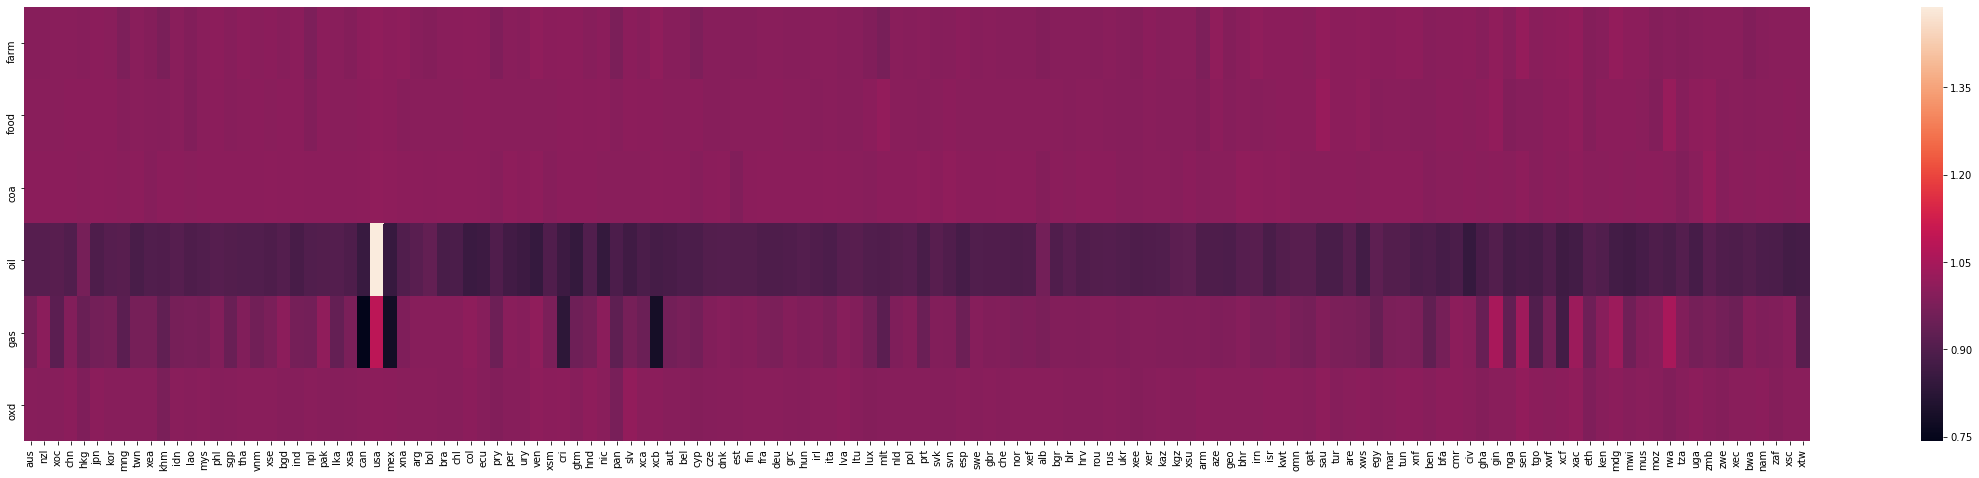

In [18]:
fig, ax = heat_map(counterfactual_dict['Y_g_hat'], C_goods, reg_2_num)

In [19]:
plt.show()

In [23]:
dataframe = pd.DataFrame(counterfactual_dict['X_g_hat'][:,:,4])

In [24]:
dataframe.set_index(dataframe.index.to_series().map(num_2_reg), inplace=True)
dataframe.rename(columns=num_2_reg, inplace=True)

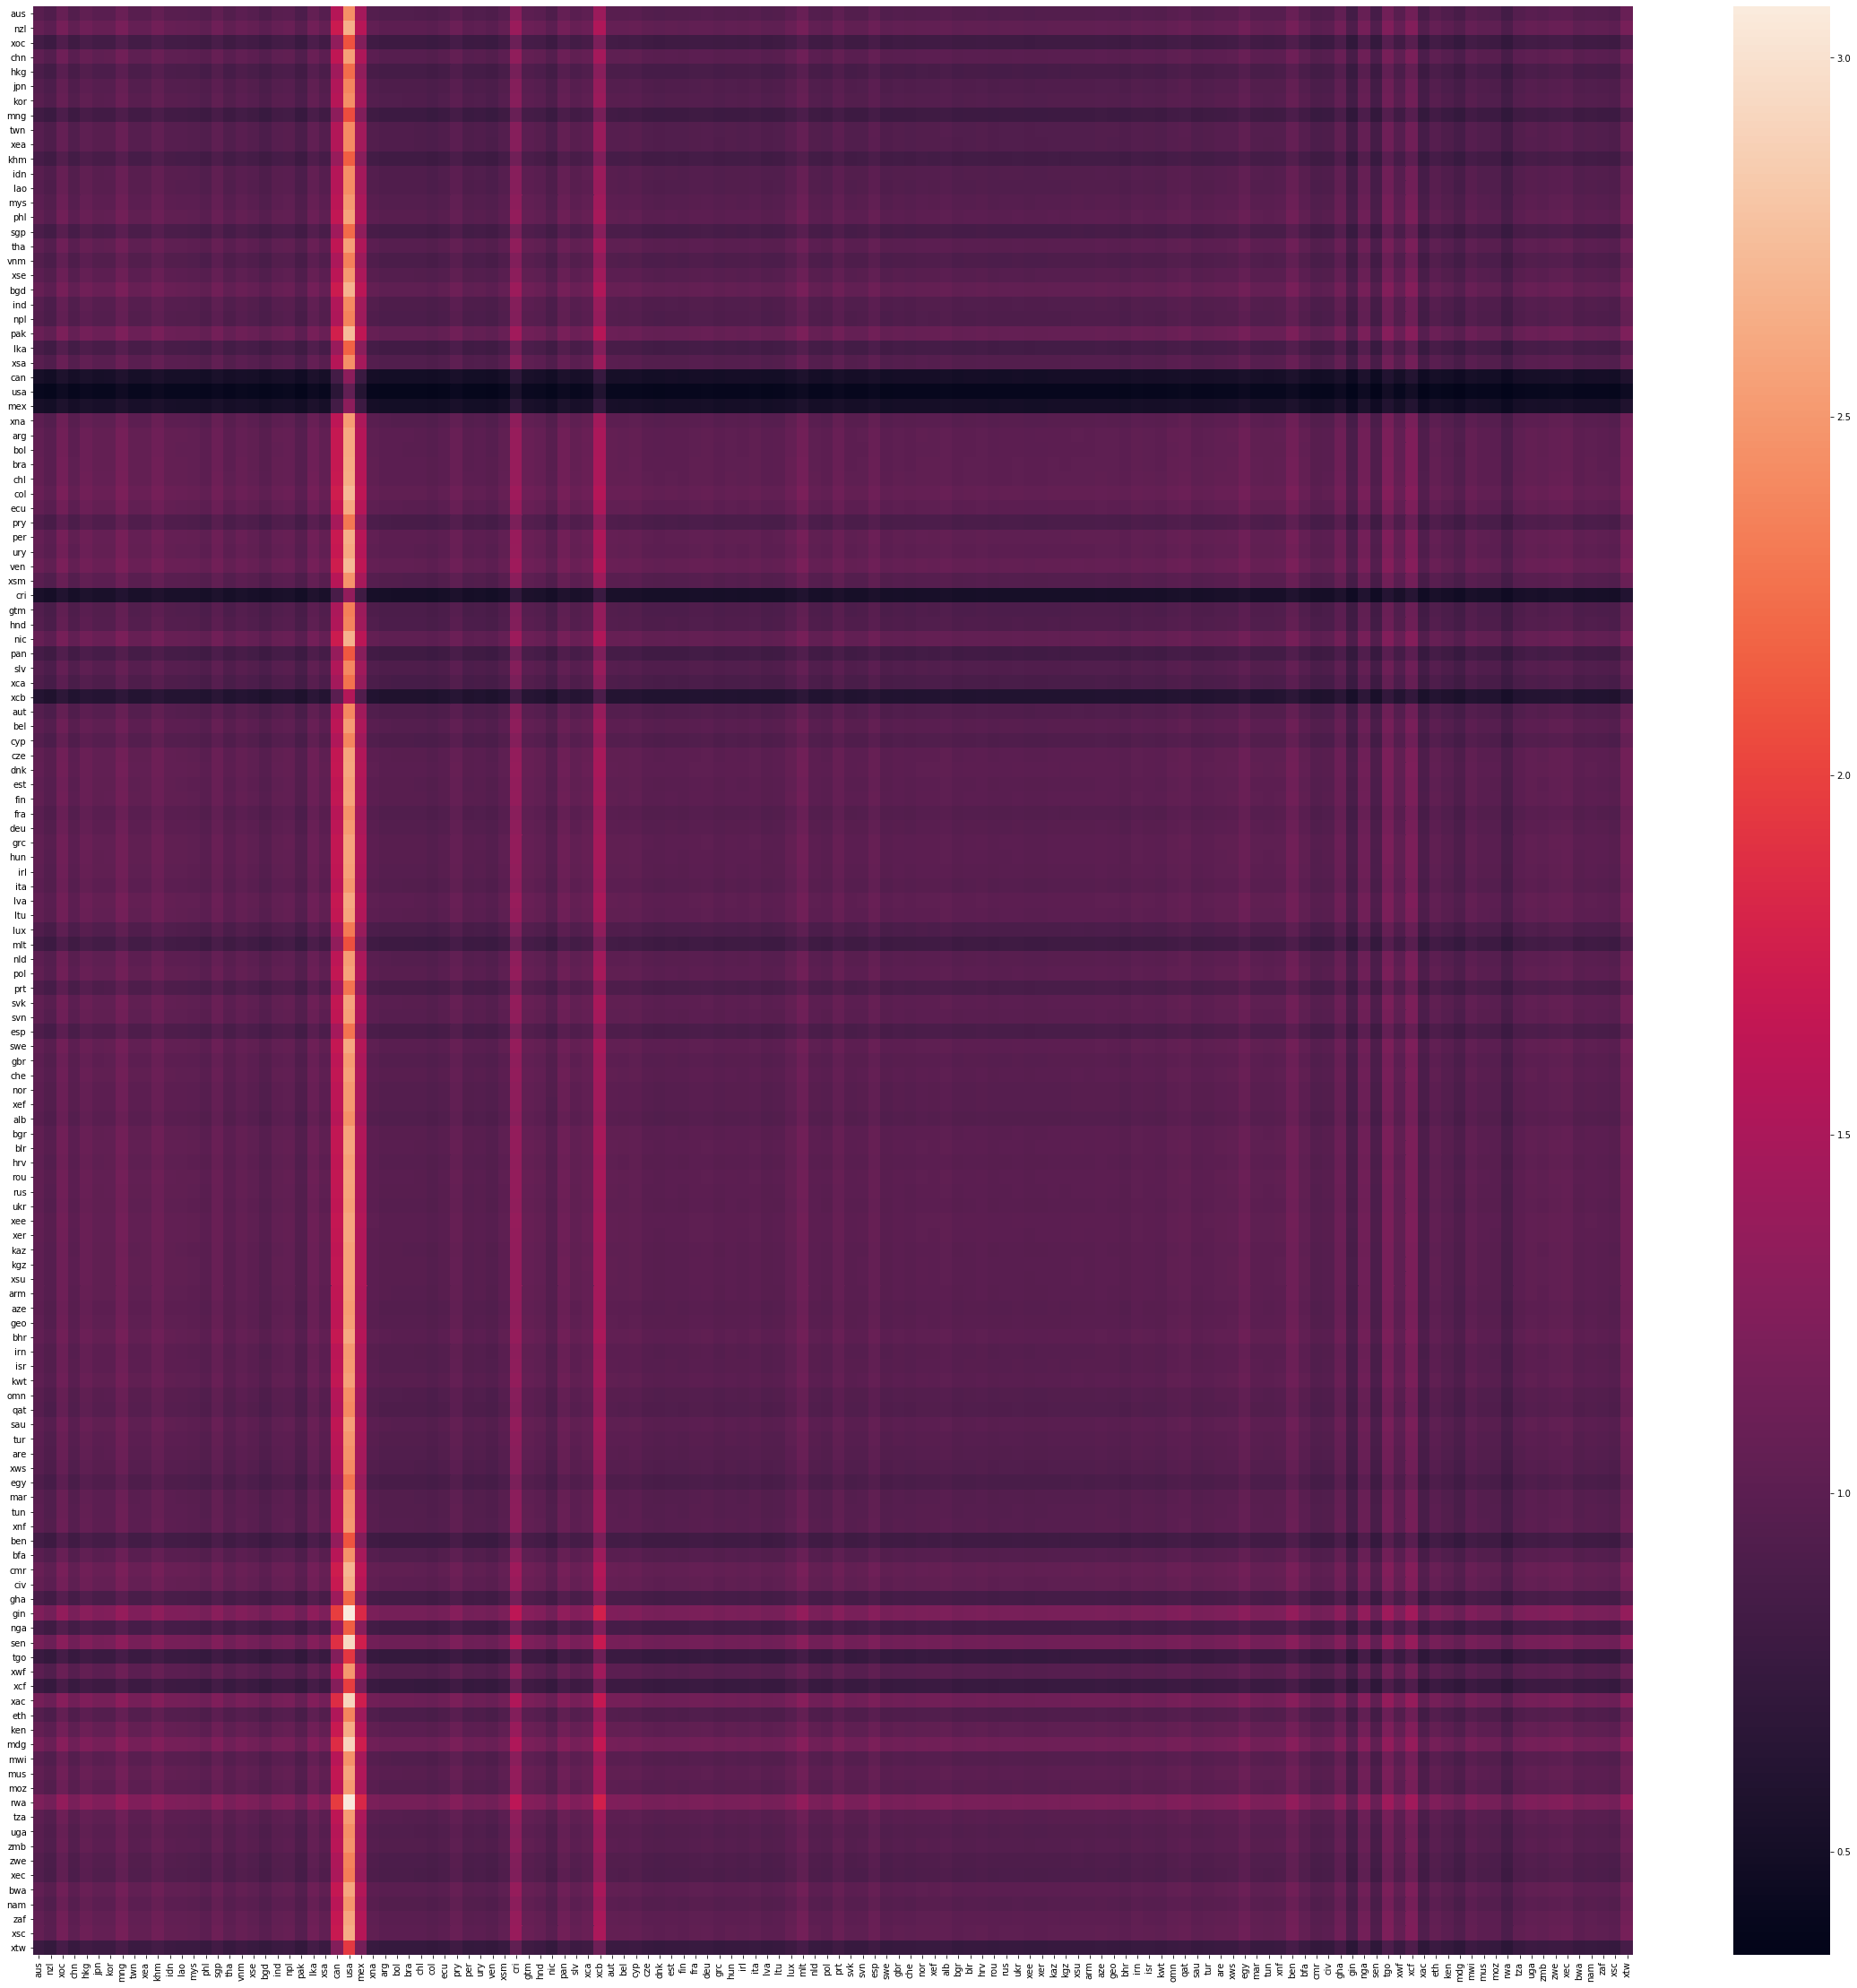

In [25]:
fig, ax = plt.subplots(figsize=(40, 40))
ax = sns.heatmap(dataframe)
plt.show()

In [25]:
counterfactual_dict['X_g_hat'][reg_2_num['usa'], reg_2_num['usa'], 3]

1.4874736114439946

In [26]:
counterfactual_dict['X_g_hat'][reg_2_num['usa'], reg_2_num['usa'], 4]

1.040584540875652

In [22]:
counterfactual_dict['D_g_hat'][reg_2_num['usa'],2]

1.0165411801831579

In [23]:
counterfactual_dict['D_g_hat'][reg_2_num['usa'],4]

0.8160917256551016

In [24]:
counterfactual_dict['D_g_hat'][reg_2_num['usa'],5]

1.0159480087496475

In [41]:
counterfactual_dict['X_g_hat'][reg_2_num['usa'], :, 5]

array([1.04966778, 1.05080663, 1.04767568, 1.05018962, 1.11500134,
       1.04472037, 1.04217635, 1.04736342, 1.04866216, 1.0482185 ,
       1.13219125, 1.04633424, 1.04891235, 1.03542021, 1.03771813,
       1.04350192, 1.03137681, 1.06628001, 1.059322  , 1.0536725 ,
       1.03963511, 1.05050907, 1.02695328, 1.03753987, 1.04764621,
       1.02567324, 1.01042043, 1.00002961, 1.02440207, 1.0509953 ,
       1.0457318 , 1.04235887, 1.0381935 , 1.00425777, 1.06042255,
       1.07911071, 1.04090544, 1.02873465, 1.03566839, 1.02390368,
       1.00029497, 0.96529017, 1.03768629, 1.00789837, 1.12128391,
       0.96679153, 1.03839468, 1.01217931, 1.04860529, 1.04224377,
       1.06810097, 1.04461822, 1.04478187, 1.06401806, 1.05163167,
       1.03829281, 1.04802547, 1.04084987, 1.05561664, 1.03578851,
       1.03431194, 1.05832958, 1.04656598, 1.06441994, 1.07010411,
       1.04314118, 1.04904422, 1.02921577, 1.05090141, 1.07331266,
       1.03194651, 1.04415819, 1.04629194, 1.04760712, 1.05013

In [ ]:
# We need to play with elasticities!